In [176]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy import interpolate

Data
---------

In [177]:
# equity
tsla = pd.read_csv("TSLA.csv")
tsla.columns = ['Date','Price','IV']
tsla.index = tsla.Date.apply(pd.Timestamp)
tsla = tsla[['Price','IV']]
tsla = tsla.sort_index()

In [178]:
# market cap and debt
data = pd.read_csv("E_D.csv")
data.columns = ['Date','mkt_cap','debt_to_cap','debt']
data.index = data.Date.apply(pd.Timestamp)
data = data[['mkt_cap','debt']]
data = data.sort_index()

In [179]:
# tsla cds data
cds = pd.read_csv("tsla_cds.csv")
cds.columns = ['Date','cds_spd']
cds.index = cds.Date.apply(pd.Timestamp)
cds = cds[['cds_spd']]
cds = cds.sort_index()

In [180]:
cmt = pd.read_csv("cmt.csv")
cmt.index = cmt.Date.apply(pd.Timestamp)
cmt = cmt.iloc[:,1:]
cmt = cmt.sort_index()

In [181]:
sw_curve = pd.read_csv("swap_fix_rate.csv")
sw_curve.index = sw_curve.Date.apply(pd.Timestamp)
sw_curve = sw_curve.iloc[:,1:]
sw_curve = sw_curve.sort_index()

Model Define
-----------

In [182]:
# def bs model for call option
def BScall(S, K, T, r, sigma):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S *norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call

# def survival prob by credit grades model
def Q(E,A,sig_a,t):
    xi = E/A
    lam = 0.3
    B = np.sqrt(sig_a**2*xi**2*t+lam**2)
    d = 1/(1-xi)*np.exp(lam**2)
    return norm.cdf(-B/2+np.log(d)/B) - d*norm.cdf(-B/2-np.log(d)/B)

Calculate A, A_sig via KVM model
-----------

In [183]:
# calculate A_value, A_sig via KMV model
df = cds.copy()
df['T'] = 5
df = df.join(data,on='Date',how='inner')
df = df.join(tsla.IV,on='Date',how='inner')
df = df.join(sw_curve['5Y'],on='Date',how='inner')

In [184]:
def KMV(x):
    tao = x[1]
    E = x[2]
    D = x[3]
    sig_e = x[4]/100
    rf = x[5]/100
    def func(x1):
        # x1[0]: asset value
        # x1[1]: asset vol
        call = BScall(x1[0],D,tao,rf,x1[1])
        d1 = (np.log(x1[0] / D) + (rf + 0.5 * x1[1] ** 2) * tao) / (x1[1] * np.sqrt(tao))
        return [call-E,x1[0]/E*norm.cdf(d1)*x1[1]-sig_e]
    return fsolve(func, [E+D,sig_e])

In [185]:
kmv_res = df.apply(KMV,axis=1,result_type = 'expand')
kmv_res.columns = ['A','A_sig']

In [186]:
kmv_res.head()

,A,A_sig
Date,,
2019-11-22,73483.802702,0.307351
2019-11-25,74090.016201,0.299468
2019-11-26,72784.142281,0.274450
2019-11-27,73181.360614,0.272154
2019-11-29,72924.205987,0.288791


Calculate CDS spd via Credit Grades model
--------------

In [187]:
def CreditGrades(x):
    A = x[0]
    E = x[2]
    sig_a = x[1]
    
    #
    tr = np.array([0,1/12,2/12,3/12,6/12,1,2,3,4,5])*4
    y_cmt = list(cmt.loc[x.name])
    y_swap = list(sw_curve.loc[x.name])
    yields = np.array([0]+y_cmt[:5]+y_swap)/4
    interp = interpolate.interp1d(tr, yields, bounds_error=False, fill_value=0,kind='linear')
    
    # calcualte cds spd
    r = 0.4
    q = 1
    count1 = 0
    count2 = 0
    for t in np.arange(0,5,0.25)+0.25:
        disf = 1/(1+float(interp(t*4))/100)**t
        q_new = Q(E,A,sig_a,t)
        # print(q,q_new)
        count1 += disf*(q-q_new)
        q = q_new
        count2 += disf*q
    return count1/count2*(1-r)*4*10000

In [188]:
cds_spd = pd.DataFrame(df2.apply(CreditGrades,axis=1,result_type='expand'))
cds_spd.columns = ['cds_prd']

In [189]:
res2 = cds.join(cds_spd,on='Date',how='inner')
res2['diff'] = res2['cds_prd']-res2['cds_spd']

In [190]:
res2

,cds_spd,cds_prd,diff
Date,,,
2019-11-22,296.985,13.908325,-283.076675
2019-11-25,284.520,11.381742,-273.138258
2019-11-26,275.000,6.501307,-268.498693
2019-11-27,282.480,5.937569,-276.542431
2019-11-29,292.330,9.254006,-283.075994
...,...,...,...
2020-11-16,173.110,26.618042,-146.491958
2020-11-17,170.600,68.693007,-101.906993
2020-11-18,170.620,108.532876,-62.087124


<AxesSubplot:xlabel='Date'>

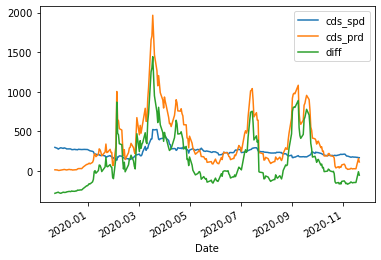

In [191]:
res2.plot()